<a href="https://colab.research.google.com/github/Brimarolafs/Gervigreind-Lokaverkefni-BJV/blob/main/Gervi_loka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Pre-processing

In [2]:
from PIL import Image
import numpy as np

def load_image(infilename, grayscale = False):
    if grayscale:
        img = Image.open( infilename ).convert('L')
    else:
        img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

def compress(infilename, size = 64, grayscale = False):
    if grayscale:
        img = Image.open(infilename).convert('L')
    else:
        img = Image.open(infilename)
    img = img.resize((size,size))
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def compression_pipeline(path_to_files, size = 64, grayscale = False):
    import os
    images = []
    for i,filename in enumerate(os.listdir(path_to_files)):
        img = compress(path_to_files + '/'+filename, size, grayscale)
        images.append(img)
    return np.array(images)

def pipeline(path_to_files, grayscale = False):
    import os
    images = []
    for i,filename in enumerate(os.listdir(path_to_files)):
        img = load_image(path_to_files + '/'+filename, grayscale)
        images.append(img)
    return np.array(images)

Import pictures

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/MyDrive/pokemon_jpg/pokemon_jpg'

pokemon_data_gray = pipeline(folder_path, grayscale = True)/255
pokemon_compressed_data_gray = compression_pipeline(folder_path, grayscale=True)/255

pokemon_data = pipeline(folder_path, grayscale = False)/255
pokemon_compressed_data = compression_pipeline(folder_path, grayscale=False)/255

(256, 256, 3)

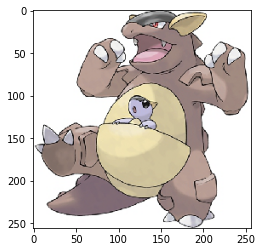

In [6]:
import matplotlib.pyplot as plt
image = pokemon_data[1]
plt.imshow(image)
image.shape

In [7]:
from scipy.signal import convolve2d as cnv


def random_mix(X, Y, prob):
    choice = np.random.choice(2, size = X.shape, p = np.array([prob, 1-prob])).astype(bool)
    return np.where(choice, X, Y)


def conv_arr(image, kernel):
    conv = np.zeros(image.shape)
    for k in range(3):
        conv[:,:,k] = cnv(image[:,:,k],kernel, mode = 'same')
    return conv

def iter_conv(image, kernel, n = 10):
    conv = image
    for i in range(n):
        conv = conv_arr(conv, kernel)
        conv = random_mix(image, conv, prob = 0.3)
    return conv
    

kernel = np.array([[0,5,10],
                   [-1,2,4],
                   [-7,-1,0]])
kernel = kernel/np.sum(kernel)
conv = iter_conv(image, kernel)



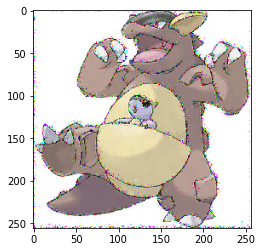

In [8]:
import matplotlib.pyplot as plt
plt.imshow(conv);

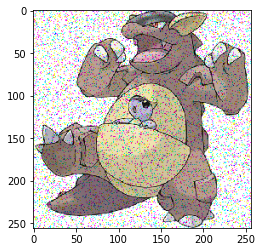

In [9]:
def add_noise_to_img(image):
    noise = np.random.normal(loc = 0, scale = 0.1, size = image.shape)
    new_img = image + noise
    return new_img/np.max(new_img)

new_img = add_noise_to_img(image)

plt.imshow(new_img)

prob = np.random.uniform(0,1, size = image.shape)

smoothing_kernel = np.array([
    [0.3,1,0.3],
    [1,1,1],
    [0.3,1,0.3]
])
smoothing_kernel = smoothing_kernel/np.sum(smoothing_kernel) 

smoothed_prob = iter_conv(prob, smoothing_kernel, n = 100)
smoothed_prob
bool_matrix = smoothed_prob >= 0.1

plt.imshow(np.where(bool_matrix, image, np.zeros(image.shape)))

In [10]:
import sklearn.model_selection
import numpy as np
from sklearn import preprocessing

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(pokemon_compressed_data, pokemon_data, test_size = 0.2, random_state = 42)
x_train_gray, x_test_gray, y_train_gray, y_test_gray = sklearn.model_selection.train_test_split(pokemon_compressed_data_gray, pokemon_data_gray, test_size = 0.2, random_state = 42)

In [11]:
#Model 1
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Activation
from keras import regularizers
from tensorflow.keras.models import Model

In [12]:
def scheduler(n,lr):
    if n <= 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def train_grayscale(autoenc_class):
    autoencoder = autoenc_class()
    autoencoder.build((None,64,64))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    l1 = keras.losses.SparseCategoricalCrossentropy()
    l2 = keras.losses.MeanSquaredError()
    autoencoder.summary()
    autoencoder.compile(optimizer=opt, loss=l2)
    autoencoder.fit(x_train_gray, y_train_gray,
                epochs=30,
                batch_size=32,
                shuffle=True,
                callbacks = [keras.callbacks.LearningRateScheduler(scheduler)],
                validation_data = (x_test_gray,y_test_gray)
                )
    return autoencoder



def train(autoenc_class):
    autoencoder = autoenc_class()
    autoencoder.build((None,64,64,3))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    l1 = keras.losses.SparseCategoricalCrossentropy()
    l2 = keras.losses.MeanSquaredError()
    autoencoder.summary()
    autoencoder.compile(optimizer=opt, loss=l2)
    autoencoder.fit(x_train, y_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                callbacks = [keras.callbacks.LearningRateScheduler(scheduler)],
                validation_data = (x_test,y_test)
                )
    return autoencoder


def get_imgs(autoencoder,x_test):
    encoded_imgs = autoencoder.encoder(x_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    return encoded_imgs,decoded_imgs

In [24]:
import matplotlib.pyplot as plt

def print_results(encoded_imgs,decoded_imgs, x_test, y_test):
    n = 8
    plt.figure(figsize=(2,n), dpi = 500)
    for i in range(n):
        ax = plt.subplot(n, 3, 3*i +1)
        plt.imshow(x_test[i])
        plt.title("in")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(n, 3, 3*i + 2)
        plt.imshow(decoded_imgs[i])
        plt.title("out")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(n, 3, 3*i + 3)
        plt.imshow(y_test[i])
        plt.title("org")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace = 2)  
    plt.show()

def print_results2(encoded_imgs,decoded_imgs,x_test,y_test, index = 0):
  #Magic
  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(12)
  plotsize = (9,9)
  ax1 = plt.subplot2grid(shape=plotsize, loc=(0, 0), rowspan=4, colspan=4, title="original")
  ax1.axis('off')

  ax2 = plt.subplot2grid(shape=plotsize, loc=(0, 4), colspan=1, title="compressed")
  ax2.axis('off')

  ax3 = plt.subplot2grid(shape=plotsize, loc=(0, 5), rowspan=4, colspan=4, title="restored")
  ax3.axis('off')
  #Plotting
  
  
  ax1.imshow(y_test[index])
  ax2.imshow(x_test[index])
  ax3.imshow(decoded_imgs[index])

In [14]:
class Autoencoder_simple_mlp(Model):
  def __init__(self):
    super(Autoencoder_simple_mlp, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Flatten()
        ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(256 * 256, activation='sigmoid'),
      layers.Reshape((256,256))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
simple_mlp_autoencoder = train_grayscale(Autoencoder_simple_mlp)

Model: "autoencoder_simple_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4096)              0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256)          268500992 
                                                                 
Total params: 268,500,992
Trainable params: 268,500,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
21/21 [==============================] - 4s 68ms/step - loss: 0.0700 - val_loss: 0.0589 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 1s 59ms/step - loss: 0.0581 - val_loss: 0.0538 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 1s 59ms/step - loss: 0.0534 - val_loss: 0.0502 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 1s 59ms/step - loss: 0.0502 - val_loss

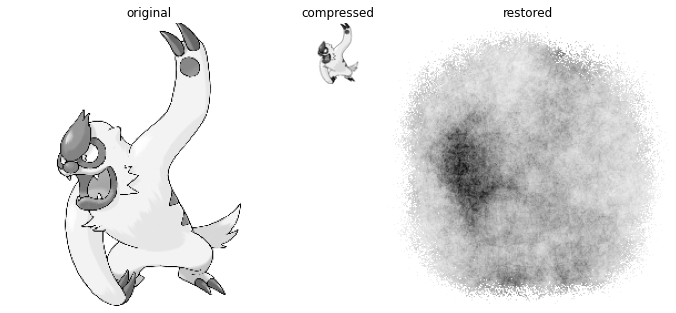

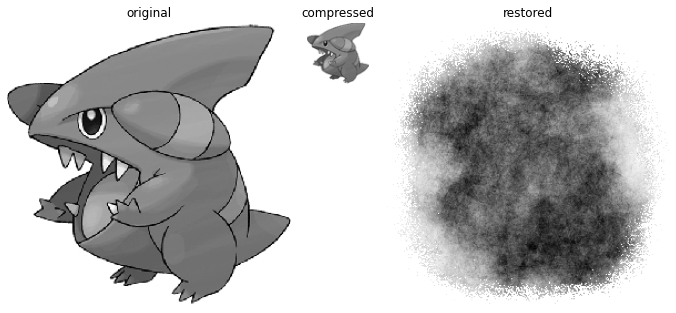

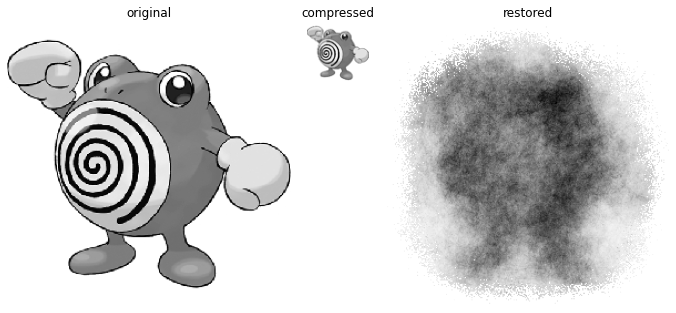

In [25]:
enc,dec = get_imgs(simple_mlp_autoencoder, x_test_gray)
print_results2(enc,dec, x_test_gray,y_test_gray, index = 0)
print_results2(enc,dec, x_test_gray,y_test_gray, index = 1)
print_results2(enc,dec, x_test_gray,y_test_gray, index = 2)
# print_results(enc,dec, x_test_gray,y_test_gray)

In [26]:
class Autoencoder_2(Model):
  def __init__(self):
    super(Autoencoder_2, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(filters = 30, kernel_size = (7,7),padding = 'same', data_format = 'channels_last',activation = 'relu'),
        layers.Conv2D(filters = 50, kernel_size = (5,5),padding = 'same', data_format = 'channels_last',activation = 'relu'),
        layers.Conv2D(filters = 200, kernel_size = (3,3), padding = 'same', data_format = 'channels_last',activation = 'relu')
        ])
    self.decoder = tf.keras.Sequential([
        layers.UpSampling2D(),
        layers.Conv2D(filters = 50, padding = 'same', kernel_size = 7),
        layers.UpSampling2D(),
        layers.Conv2D(filters = 30, padding = 'same', kernel_size = 5),
        layers.Conv2D(filters = 15, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 7, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 5, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 3, padding = 'same', kernel_size = 1)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [27]:
adv_autoencoder = train(Autoencoder_2)

Model: "autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 64, 64, 200)       132190    
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       532935    
                                                                 
Total params: 665,125
Trainable params: 665,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
21/21 [==============================] - 34s 796ms/step - loss: 0.5064 - val_loss: 0.0585 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 12s 570ms/step - loss: 0.0422 - val_loss: 0.0325 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 12s 558ms/step - loss: 0.0297 - val_loss: 0.0257 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 12s 555ms/step - loss: 0.0245 - val_loss: 0.0223 

In [30]:
enc,dec = get_imgs(adv_autoencoder, x_test)

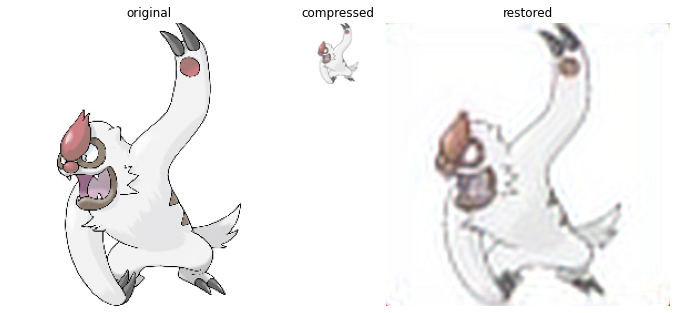

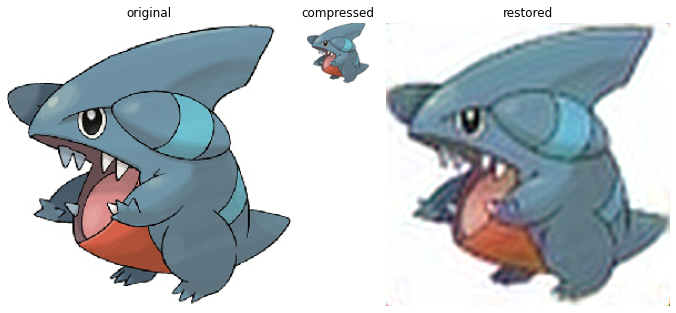

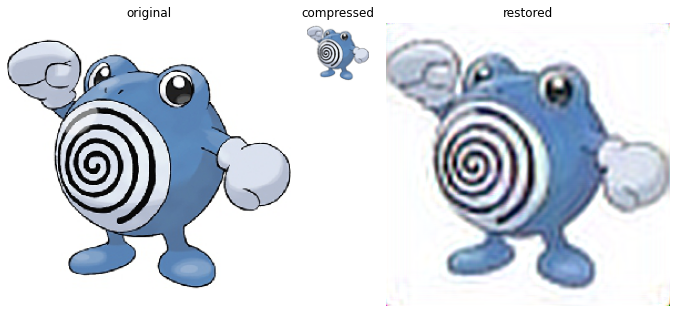

In [31]:
print_results2(enc,dec, x_test,y_test, index = 0)
print_results2(enc,dec, x_test,y_test, index = 1)
print_results2(enc,dec, x_test,y_test, index = 2)